## ASTR 597A Homework 4
Eric Bellm

Due Jan 31, 2023

Your name: David
    
Your collaborators:

## Installation

This homework does not use the DP0.2 simulated data, and the `rubin_sim` package that includes the Metrics Analysis Framework (MAF) is not installed by default on `data.lsst.cloud`.  You may install and run `rubin_sim` on the `data.lsst.cloud` RSP instance, on your personal computer, or on a shared server like `epyc`.

You will need to install the `rubin_sim` package according to the directions at https://github.com/lsst/rubin_sim.

You can get more information about MAF from https://rubin-sim.lsst.io/ as well as the [rubin_sim_notebooks](https://github.com/lsst/rubin_sim_notebooks) tutorial notebooks; some of this material was adapted from those tutorials.

Note that in late 2022 many of the APIs in MAF were changed, as discussed in the [release notes](https://github.com/lsst/rubin_sim/releases), so you may find older materials which require some adjustment to use.

## Setup

Let's confirm that rubin_sim is working and that we can use MAF on the current baseline cadence.

In [2]:
import numpy as np

In [3]:
import rubin_sim
from rubin_sim import maf
from rubin_sim.maf.run_comparison import archive
rubin_sim.__version__

'1.0.0'

In [4]:
opsim_fname = rubin_sim.data.get_baseline()
print(opsim_fname)

/home/ykwang1/rubin_sim_data/sim_baseline/baseline_v3.0_10yrs.db


In [5]:
from os.path import splitext, basename

run_name = splitext(basename(opsim_fname))[0]
print(run_name)

baseline_v3.0_10yrs


At the time of this writing the baseline is `baseline_v3.0_10yrs`.

Let's find a basic metric to run.  `CoaddM5` is provides the final coadded depth of the ten-year survey:

In [6]:
# list all pre-installed metrics
# maf.BaseMetric.help()

In [7]:
#help(maf.Coaddm5Metric)

Let's make plots of this metric for the `r` band as a spatial (healpix) map as well as a 1-d histogram, and then compute some summary statistics.

In [8]:
# choose the spatial slicer
slicer = maf.slicers.HealpixSlicer(nside=64)

# choose the metric
metric =  maf.metrics.Coaddm5Metric()

# only r-band
constraint = "filter = 'r'"

# choose how to plot"
plot_funcs = [maf.plots.HealpixSkyMap(), maf.plots.HealpixHistogram()]
plot_dict = {'nside': 64, 'colorMin': 0}

# define the summary metrics
summary_metrics = [maf.metrics.MinMetric(), maf.metrics.MedianMetric(), maf.metrics.MaxMetric(), 
                 maf.metrics.PercentileMetric(percentile=25), maf.metrics.PercentileMetric(percentile=75)]

# wrap it up
bundle = maf.metricBundles.MetricBundle(metric, slicer, constraint=constraint, run_name=run_name,
                                        plot_dict=plot_dict, plot_funcs=plot_funcs,
                                        summary_metrics=summary_metrics)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


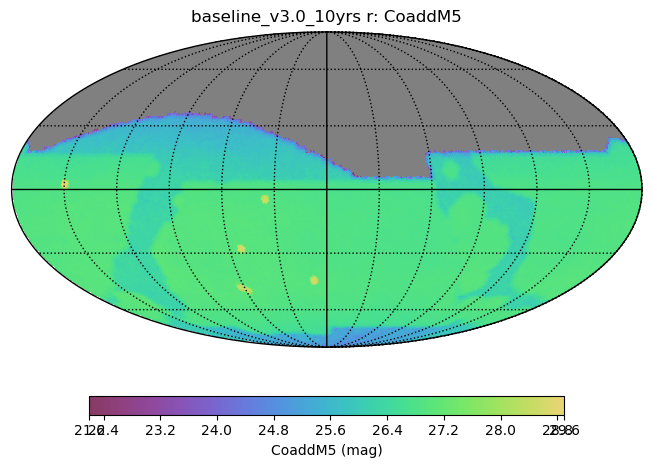

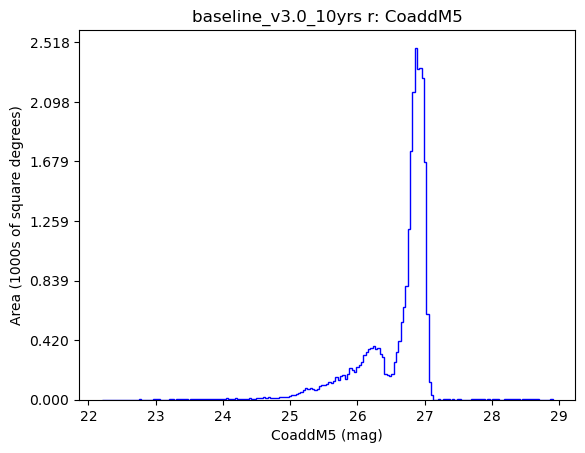

In [9]:
out_dir = 'example'

bdict = {'example':bundle}
bgroup = maf.metricBundles.MetricBundleGroup(bdict, opsim_fname, out_dir=out_dir)
bgroup.run_all()
bgroup.plot_all(closefigs=False)

In [10]:
bdict['example'].summary_values

{'Min': 22.198008581186244,
 'Median': 26.818286779940127,
 'Max': 28.901333351511354,
 '25th%ile': 26.36466151384583,
 '75th%ile': 26.923352127895672}

## Exercise 1: Counts

Let's get a sense of how the LSST divides its exposures.  Use `UniSlicer`, `CountMetric`, and appropriate SQL constraints to provide counts of the total exposures by filter.  The OpSim schema is described [here](https://rubin-sim.lsst.io/rs_scheduler/output_schema.html).

In [13]:
# use UniSlicer to get all obs
slicer = maf.slicers.UniSlicer()

# choose the metric
metric =  maf.metrics.CountMetric(col='cloud')

for band in 'ugrizy':
    constraint = "filter = '{}'".format(band)
    test = maf.metricBundles.MetricBundle(metric, slicer, constraint=constraint, run_name=run_name)

    example1_bg = maf.MetricBundleGroup(
        [test], opsim_fname
    )

    example1_bg.run_all()


    print(band, test.metric_values)

u [112379.0]
g [190012.0]
r [483457.0]
i [494436.0]
z [405122.0]
y [400673.0]


## Exercise 2: Cloudy

What is the mean cloud cover for exposures taken during the simulated baseline survey?  Plot a histogram of the cloud cover.

In [42]:
cloud_opsim_db = opsim_fname
cloud_slicer = maf.OneDSlicer(
    slice_col_name="cloud", bin_min=0, bin_max=1, binsize=0.05
)
cloud_metric = maf.CountMetric(col="cloud")
cloud_bundle = maf.MetricBundle(
    cloud_metric,
    cloud_slicer,
    run_name=run_name,
    summary_metrics=[maf.metrics.MeanMetric()]
)

In [43]:
cloud_bg = maf.MetricBundleGroup(
    [cloud_bundle], cloud_opsim_db
)

In [44]:
cloud_bg.run_all()

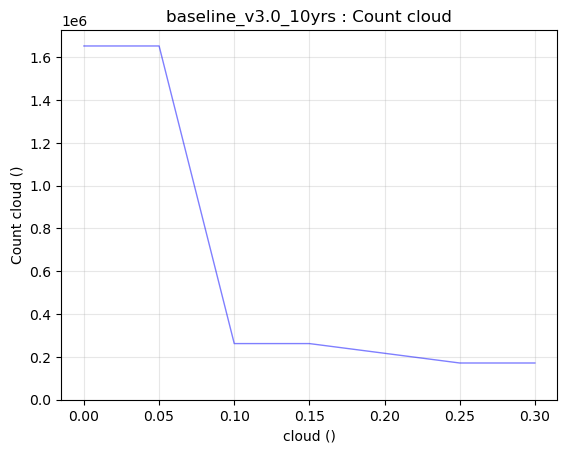

In [22]:
cloud_bg.plot_all(closefigs=False)

In [27]:
cloud_data = cloud_bundle.metric_values.data

In [29]:
cloud_data

array([1.652312e+006, 8.163506e-318, 2.622290e+005, 9.459089e-318,
       9.459089e-318, 1.715380e+005, 1.030660e-317, 1.030660e-317,
       1.030660e-317, 1.030660e-317, 1.030660e-317, 1.030660e-317,
       1.030660e-317, 1.030660e-317, 1.030660e-317, 1.030660e-317,
       1.030660e-317, 1.030660e-317, 1.030660e-317, 1.030660e-317])

In [36]:
cloud_bins=cloud_bundle.slicer.slice_points['bins']


In [48]:
import matplotlib.pyplot as plt


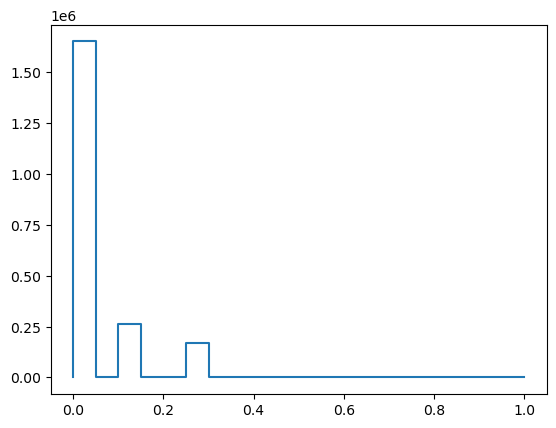

In [47]:
plt.step(cloud_bins, [0] + list(cloud_data))
plt.show()

In [52]:
sum(cloud_data * cloud_bins[:-1]) / sum(cloud_data)

0.033127892088458774

## Exercise 3: Comparisons

MAF was built to compare evaluate the impact of different observing strategies on various science cases.  You can always write new metrics and run them yourself on multiple OpSim simulations.  This can be time consuming, though.  For many standard metrics, the metric values for various runs are stored in queryable tables--see the [04_Getting_Data](https://github.com/lsst/rubin_sim_notebooks/blob/main/maf/tutorial/04_Getting_Data.ipynb) tutorial notebook.

### 3a

In this exercise we'll get a small taste of the tradeoffs confronted by the Survey Cadence Optimization Committee.

Make a mesh plot of the metric summary values for the metric sets `"DESC WFD"` (Cosmology), `"TVS XRB"` (Galactic Transients), and `"SSO discovery"` (Solar System science) on run families `"baseline"`, `"galactic plane footprint"`, amd `"rolling"`.  Set `baseline_run='baseline_v2.0_10yrs'` to compare to one of the earlier baseline cadences.  Qualitatively, how does the new (v3.0) baseline cadence look for these metrics?  What other trends do you see across these run families?  

### 3b (optional)

Look through the list of metric sets and identify which one(s) are most closely associated with your scientific interests.  What has been the trend of these metrics in the `"baseline"` run family?  Make a plot with `maf.plot_run_metric`.

## Exercise 4: Lightcurves

Some metrics take simulated events and generate the data points as they would be observed by LSST.  Typically these lightcurves are only used internally to compute higher-level metrics, but some metrics make it possible to return the generated lightcurves.

Use the `KNePopMetric` with `output_lc=True` to generate random kilonova lightcurves as observed by LSST.  Plot an event with at least ten data points.

The [kilonova](https://github.com/lsst/rubin_sim_notebooks/blob/main/maf/science/KNeMetric.ipynb) and [XRB](https://github.com/lsst/rubin_sim_notebooks/blob/main/maf/science/XRB_Metric.ipynb) science notebooks will be helpful.